In [634]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine as p9
import os
import warnings
from scipy import stats
from sklearn import metrics

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_rows = 999
p9.options.figure_size = (10,7)

In [382]:
PATH = '/MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/'
PATH_I = os.path.join(PATH,'images')

In [570]:
tex_theme = theme(plot_background = element_rect(fill = '#fafafa', color = '#fafafa'), axis_text_x=element_text(size=12),
         axis_text_y=element_text(size=12), axis_title_x=element_text(size=15), axis_title_y=element_text(size=15),
        legend_background = element_rect(fill="#fafafa"), legend_title=element_text(size=15),legend_text=element_text(size=12),
         legend_position=(.8,.7))
tex_theme2 = theme(plot_background = element_rect(fill = '#fafafa', color = '#fafafa'), axis_text_x=element_text(size=12),
         axis_text_y=element_text(size=12), axis_title_x=element_text(size=15), axis_title_y=element_text(size=15),
        legend_background = element_rect(fill="#fafafa"), legend_title=element_text(size=10),legend_text=element_text(size=12))
tex_theme_blank = theme(plot_background = element_rect(fill = '#fafafa', color = 'black'), axis_text_x=element_blank(),
          axis_text_y=element_blank(),axis_ticks=element_blank(),
          axis_title_x=element_blank(),axis_title_y=element_blank())
blank_theme = theme(axis_line=element_blank(),axis_text_x=element_blank(),
          axis_text_y=element_blank(),axis_ticks=element_blank(),
          axis_title_x=element_blank(),axis_title_y=element_blank(),
          panel_background=element_blank(),panel_border=element_blank(),panel_grid_major=element_blank(),
          panel_grid_minor=element_blank(),
           plot_background = element_rect(fill = '#fafafa', color = '#fafafa'))



# Distribution plots

In [107]:
def norm_line(ptct,grp,mn=0,sd=1):
    x = np.linspace(mn-sd*4,mn+sd*4,ptct)
    y = 1/np.sqrt(2*np.pi*sd**2) * np.exp(-1*(x-mn)**2/(2*sd**2))
    df = pd.DataFrame({'x':x,'y':y,'grp':grp})
    return df    

In [91]:
from plotnine import * 
from plotnine.data import *

In [251]:
def norm_line(ptct,grp,mn=0,sd=1,y_lab=1):
    x = np.linspace(mn-sd*4,mn+sd*4,sd*8*ptct+1)
    y = 1/np.sqrt(2*np.pi*sd**2) * np.exp(-1*(x-mn)**2/(2*sd**2))
    cdf = np.round(stats.norm.cdf(x,loc=mn,scale=sd),2)
    df = pd.DataFrame({'x':x,'y':y,'cdf':cdf,'Disease':grp,'y_lab':y_lab})
    return df  

In [219]:
df1 = norm_line(ptct=5,grp='Positive',mn=45,sd=7)
df2 = norm_line(ptct=5,grp='Negative',mn=35,sd=5)
df_grp = pd.concat([df1,df2])
thresh = 40
max_val = 1.2*max(df2.y.max(),df1.y.max())
df3 = pd.DataFrame({'x':[thresh, thresh],'y':[0,max_val]})

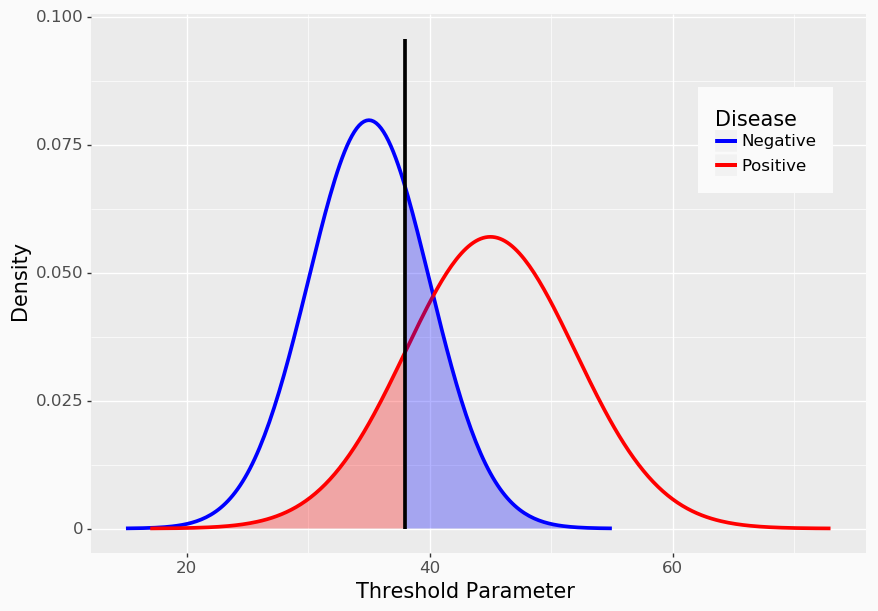

<ggplot: (12899904)>

In [274]:
# df_grp.reset_index(inplace=True, drop=True)
# p = (ggplot(df, aes(x='date', y='value',color='variable'))
thresh = 38
max_val = 1.2*max(df2.y.max(),df1.y.max())
df3 = pd.DataFrame({'x':[thresh, thresh],'y':[0,max_val]})
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
    + geom_line(size=1.5)
    + scale_color_manual(['b','r'])
    + geom_area(df1.loc[df1.x<=(thresh+.1),:],aes('x', 'y'),fill='red',alpha=0.3,show_legend=False, color=None)
    + geom_area(df2.loc[df2.x>=(thresh-.1),:],aes('x', 'y'),fill='blue',alpha=0.3,show_legend=False, color=None)
    + geom_line(df3,aes('x','y'),color='k',size=1.5,show_legend=False)
    + xlab('Threshold Parameter')
    + ylab('Density')
    + tex_theme )
p
# p.save(f'{PATH_I}/overlap_distr.pdf')

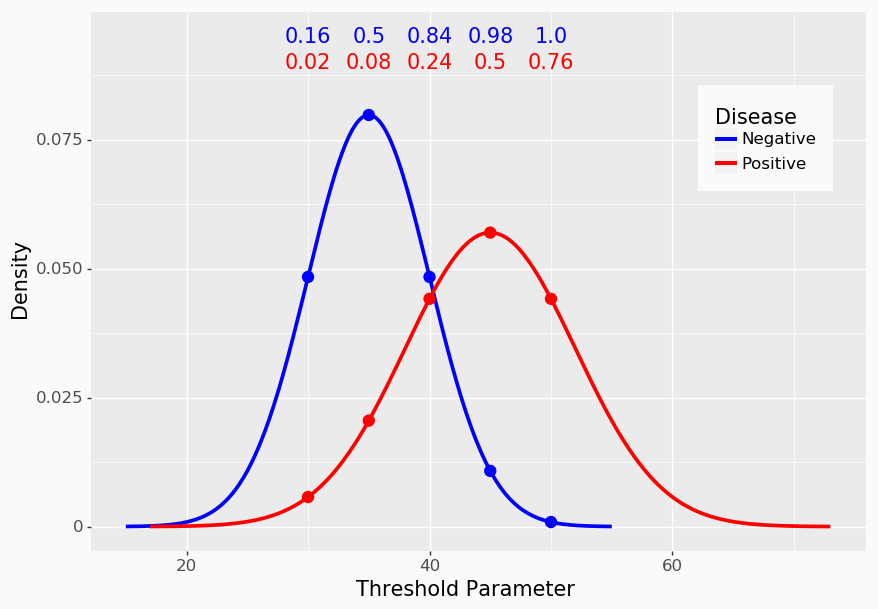

<ggplot: (12851169)>

In [296]:
df1 = norm_line(ptct=5,grp='Positive',mn=45,sd=7,y_lab=0.09)
df2 = norm_line(ptct=5,grp='Negative',mn=35,sd=5,y_lab=0.095)
df_grp = pd.concat([df1,df2],ignore_index=True)
df_pts = df_grp.loc[df_grp.x.isin(range(30,55,5)),:]
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
     + geom_line(size=1.5)
     + geom_point(df_pts, aes(x='x', y='y',color='Disease'), size=4, show_legend=False)
     + geom_text(df_pts,aes(x='x', y='y_lab',color='Disease',label='cdf'),size=15, show_legend=False)
     + scale_color_manual(['b','r'])
     + xlab('Threshold Parameter')
     + ylab('Density')
     + tex_theme)
p
# p.save(f'{PATH_I}/overlap_distr_points.pdf')

In [321]:
sens = df_pts.loc[df_pts.Disease=='Positive',['x','cdf']].reset_index(drop=True)
sens.cdf = 1-sens.cdf
spec = df_pts.loc[df_pts.Disease=='Negative',['x','cdf']].reset_index(drop=True)
odds_ratio = sens.copy()
odds_ratio.rename(columns={'cdf':'sens'},inplace=True)
odds_ratio['spec'] = spec.cdf
odds_ratio['odds'] = odds_ratio.sens/(0.999-odds_ratio.spec)
odds_ratio['ppv'] = odds_ratio.sens/(odds_ratio.sens + (1-odds_ratio.spec))
odds_ratio['npv'] = odds_ratio.spec/((1-odds_ratio.sens) + odds_ratio.spec)
odds_ratio['f1'] = 2/(1/odds_ratio.sens + 1/odds_ratio.ppv)
odds_ratio

x  sens  spec        odds       ppv       npv        f1
0  30.0  0.98  0.16    1.168057  0.538462  0.888889  0.695035
1  35.0  0.92  0.50    1.843687  0.647887  0.862069  0.760331
2  40.0  0.76  0.84    4.779874  0.826087  0.777778  0.791667
3  45.0  0.50  0.98   26.315789  0.961538  0.662162  0.657895
4  50.0  0.24  1.00 -240.000000  1.000000  0.568182  0.387097

In [355]:
Thresh = odds_ratio.x.tolist()
TP = odds_ratio.sens.round(3).tolist()
FN = (1-odds_ratio.sens).round(3).tolist()
TN = odds_ratio.spec.round(3).tolist()
FP = (1-odds_ratio.spec).round(3).tolist()
prcnt = 0.75
# for i in prcnt:
TP = np.array([round(prcnt*x,3) for x in TP])
FN = np.array([round(prcnt*x,3) for x in FN])
TN = np.array([round((1-prcnt)*x,3) for x in TN])
FP = np.array([round((1-prcnt)*x,3) for x in FP])
PPV = np.round(TP/(TP+FP),3)
NPV = np.round(TN/(TN+FN),3)
sens = TP/(TP+FN)
F1 = np.round(2/(1/sens + 1/PPV),3)

print(f'PPV:{PPV}')
print(f'NPV:{NPV}')
print(f'f1:{F1}')

PPV:[0.778 0.847 0.934 0.987 1.   ]
NPV:[0.727 0.676 0.538 0.395 0.305]
f1:[0.867 0.882 0.838 0.664 0.387]


In [350]:
2/(1/sens + 1/PPV)

array([0.43555556, 0.53784615, 0.67863074, 0.64106246, 0.38709677])

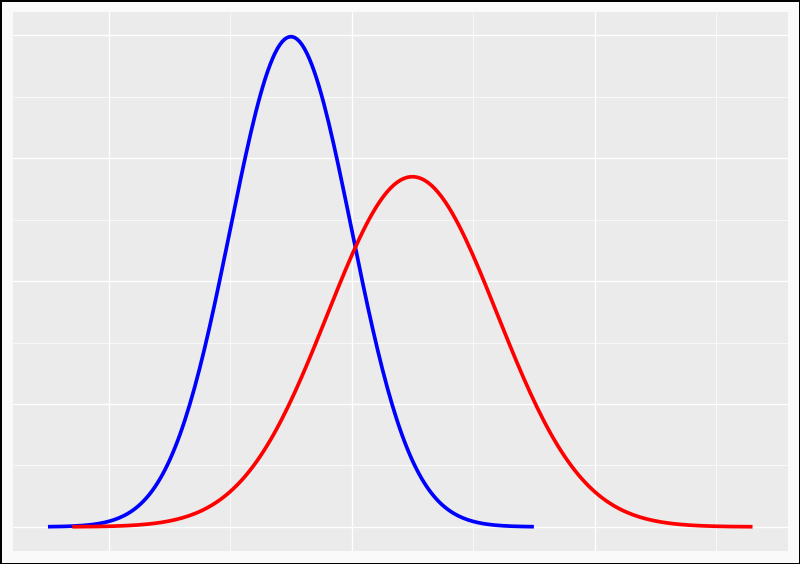

<ggplot: (-9223372036842656901)>

In [147]:
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
    + geom_line(size=1.5,show_legend=False)
    + scale_color_manual(['b','r'])
    + xlab('Threshold')
    + ylab('Density')
    + tex_theme_blank)
p
# p.save(f'{PATH_I}/overlap_distr_no_thresh.pdf')

In [380]:
df1 = norm_line(ptct=5,grp='Positive',mn=45,sd=7,y_lab=0.09)
df1_2 = norm_line(ptct=5,grp='Positive',mn=40,sd=7,y_lab=0.09)
df1_3 = norm_line(ptct=5,grp='Positive',mn=35,sd=7,y_lab=0.09)
df2 = norm_line(ptct=5,grp='Negative',mn=35,sd=5,y_lab=0.095)
df_grp = pd.concat([df1,df2],ignore_index=True)
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
    + geom_line(size=1.5,show_legend=False)
    + geom_line(df1_2,aes('x','y'),color='g',size=1.5)
    + geom_line(df1_3,aes('x','y'),color='k',size=1.5)
    + scale_color_manual(['b','r'])
    + xlab('Threshold')
    + ylab('Density')
    + tex_theme_blank)
# p
p.save(f'{PATH_I}/overlap_distr_no_thresh_diff_sens.pdf')

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:688: UserWarning: Saving 10 x 7 in image.
  from_inches(height, units), units))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:689: UserWarning: Filename: /MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/images/overlap_distr_no_thresh_diff_sens.pdf
  warn('Filename: {}'.format(filename))


In [209]:
thresh = 47
max_val = 1.2*max(df2.y.max(),df1.y.max())
df3 = pd.DataFrame({'x':[thresh, thresh],'y':[0,max_val]})
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
    + geom_line(size=1.5)
    + scale_color_manual(['b','r'])
    + geom_area(df1.loc[df1.x<=(thresh+.1),:],aes('x', 'y'),fill='red',alpha=0.3,show_legend=False, color=None)
    + geom_area(df2.loc[df2.x>=(thresh-.1),:],aes('x', 'y'),fill='blue',alpha=0.3,show_legend=False, color=None)
    + geom_line(df3,aes('x','y'),color='k',size=1.5,show_legend=False)
    + xlab('Threshold')
    + ylab('Density')
    + tex_theme )
p.save(f'{PATH_I}/overlap_distr_thi.pdf')

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:688: UserWarning: Saving 10 x 7 in image.
  from_inches(height, units), units))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:689: UserWarning: Filename: /MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/images/overlap_distr_thi.pdf
  warn('Filename: {}'.format(filename))


In [90]:
f'{PATH_I}test2.pdf'

'/MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/imagestest2.pdf'

# ROC curve

In [289]:
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})

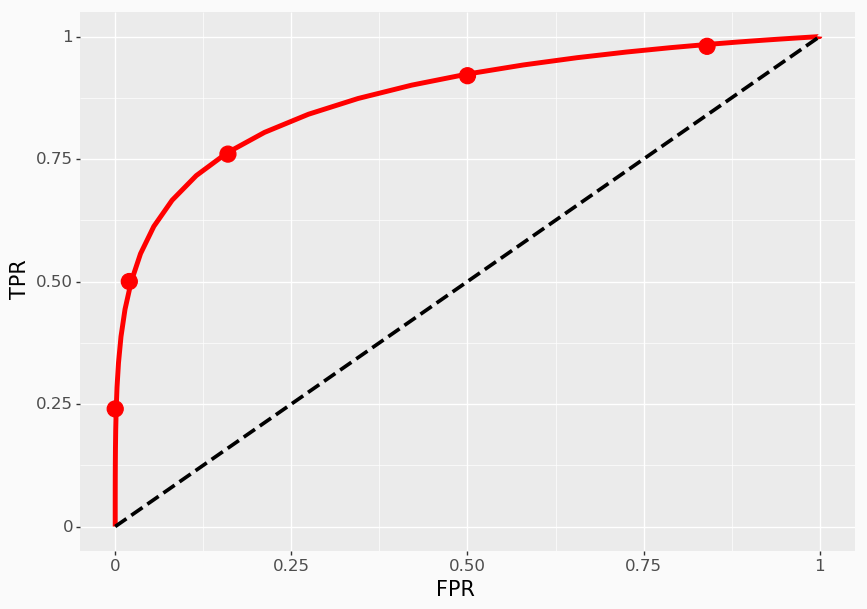

<ggplot: (-9223372036839214855)>

In [372]:
odds_ratio2 = odds_ratio.copy()
odds_ratio2['fpr'] = 1-odds_ratio2.spec
cdf_pos=stats.norm.cdf(range(100,0,-1), scale=7, loc=45)
cdf_neg=stats.norm.cdf(range(100,0,-1), scale=5, loc=35)
df_cdf = pd.DataFrame({'TPR':1-cdf_pos,'FPR':1-cdf_neg})
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})
p2 = (ggplot() + geom_line(df_cdf,aes('FPR','TPR'),size=2, color='r')  
      + geom_line(diag, aes('x','y'),linetype='dashed',color='k',size=1.5) 
      + geom_point(odds_ratio2, aes(x='fpr',y='sens'),color='r',size=6)
      + tex_theme
     )
    
p2

In [373]:
p2.save(f'{PATH_I}/ROC.pdf')

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:688: UserWarning: Saving 10 x 7 in image.
  from_inches(height, units), units))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:689: UserWarning: Filename: /MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/images/ROC.pdf
  warn('Filename: {}'.format(filename))


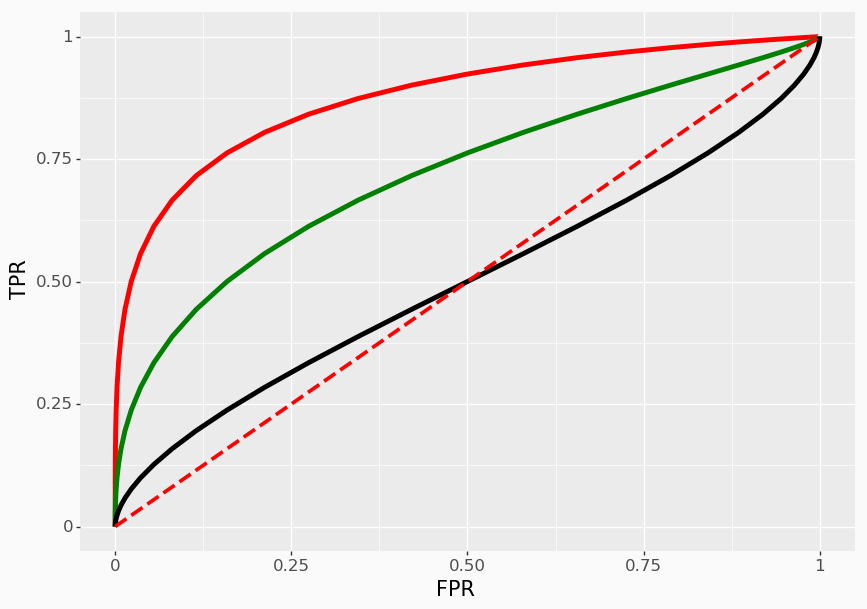

<ggplot: (-9223372036840932699)>

In [375]:
cdf_pos=stats.norm.cdf(range(100,0,-1), scale=7, loc=45)
cdf_pos2=stats.norm.cdf(range(100,0,-1), scale=7, loc=40)
cdf_pos3=stats.norm.cdf(range(100,0,-1), scale=7, loc=35)
cdf_neg=stats.norm.cdf(range(100,0,-1), scale=5, loc=35)
df_cdf = pd.DataFrame({'TPR':1-cdf_pos,'FPR':1-cdf_neg})
df_cdf2 = pd.DataFrame({'TPR':1-cdf_pos2,'FPR':1-cdf_neg})
df_cdf3 = pd.DataFrame({'TPR':1-cdf_pos3,'FPR':1-cdf_neg})
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})
p2 = (ggplot() + geom_line(df_cdf,aes('FPR','TPR'),size=2,color='r') 
      + geom_line(df_cdf2,aes('FPR','TPR'),size=2, color='g')
      + geom_line(df_cdf3,aes('FPR','TPR'),size=2, color='k')
      + geom_line(diag, aes('x','y'),linetype='dashed',color='r',size=1.5) 
      + tex_theme
     )
    
p2
# p2.save(f'{PATH_I}/ROC_dist_diff.pdf')

# AUC vs prevalence

In [321]:
cdf_pos=stats.norm.cdf(range(100,0,-1), scale=1, loc=50)
# cdf_neg=stats.norm.cdf(range(100,0,-1), scale=5, loc=35)

In [322]:
cdf_pos

array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       9.99999999e-001, 9.99999713e-001, 9.99968329e-001, 9.98650102e-001,
       9.77249868e-001, 8.41344746e-001, 5.00000000e-001, 1.58655254e-001,
       2.27501319e-002, 1

In [ ]:
p = (ggplot(df_grp, aes(x='x', y='y',color='Disease'))
p = (ggplot(cdf_pos)     
    + geom_line(size=1.5,show_legend=False)
    + scale_color_manual(['b','r'])
    + xlab('Threshold')
    + ylab('Density')
    + tex_theme_blank)

In [331]:
y.sum()

49.89997285406799

In [4]:
x = np.linspace(0,100,10**4)
y1 = stats.norm.pdf(x,40,4)
y2 = stats.norm.pdf(x,25,5)
pos = 0.65
y1 = y1*pos
y2 = y2*(1-pos)
# y.sum()

64.99350000000001 34.996490020146716


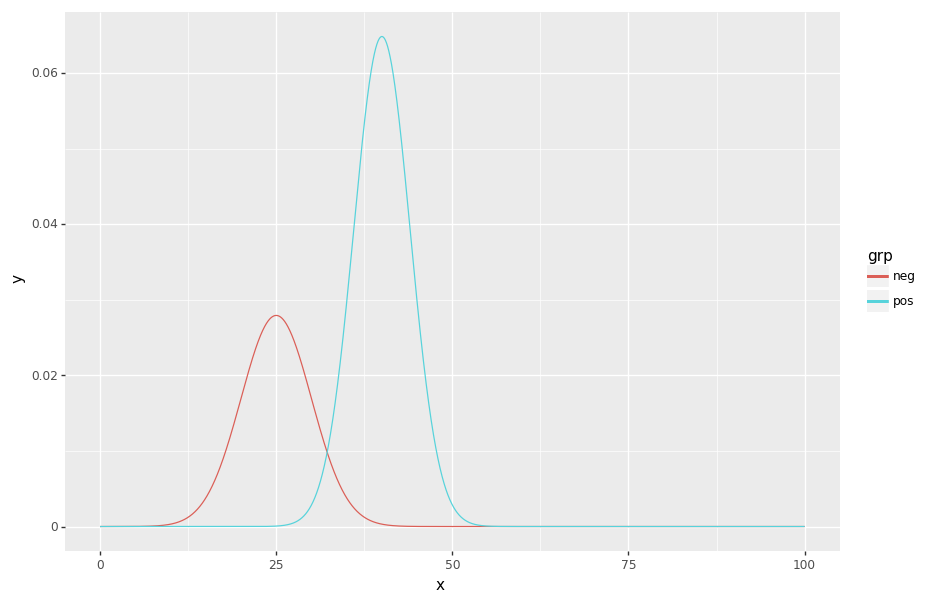

<ggplot: (12080399)>

In [5]:
df1 = pd.DataFrame({'x':x,'y':y1,'grp':'pos'})
df2 = pd.DataFrame({'x':x,'y':y2,'grp':'neg'})
df_grp = pd.concat([df1,df2])
print(y1.sum(),y2.sum())
ggplot(df_grp,aes('x','y',color='grp')) + geom_line()

In [13]:
df_dif = pd.DataFrame({'x':x,'pos':y1,'neg':y2})
df_dif.loc[df_dif.x<=40,['pos','neg']].sum().tolist()

[32.49026718632246, 34.949217359040816]

In [17]:
stats.norm.cdf(40,loc=40,scale=4)*.65

0.325

In [53]:
eps = 10**-20
mn_p = 40
mn_n = 25
scl_p = 5
scl_n = 4
prp_p = 0.65
prp_n = 1-prp_p
TN, FN = [], []
TN = stats.norm.cdf(range(100),loc=mn_n,scale=scl_n)*prp_n
FN = stats.norm.cdf(range(100),loc=mn_p,scale=scl_p)*prp_p
TP = prp_p-FN
FP = prp_n-TN
sens = (TP+eps)/(TP+FN+eps)
spec = (TN+eps)/(TN+FP+eps)
PPV = (TP+eps)/(TP+FP+eps)
NPV = (TN+eps)/(TN+FN+eps)

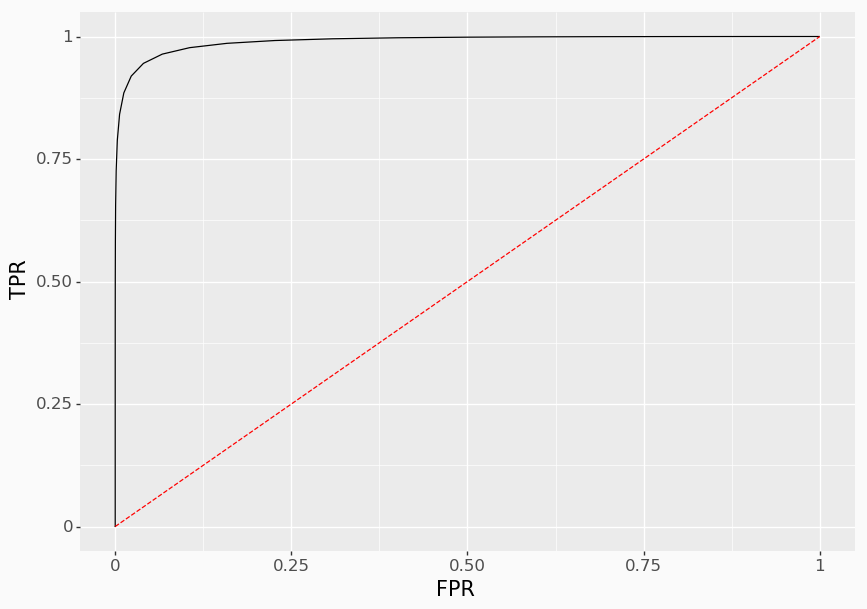

<ggplot: (12118988)>

In [55]:
df_cdf = pd.DataFrame({'TPR':sens,'FPR':1-spec})
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})
p2 = ggplot() + geom_line(df_cdf,aes('FPR','TPR'))  + geom_line(diag, aes('x','y'),linetype='dashed',color='r') + tex_theme
p2

In [112]:
eps = 10**-20
mn_p_val = [30]
mn_n_val = [25]
# mn_p = 40
# mn_n = 25
scl_p = 7
scl_n = 4
prp_p_val = [.95] #np.linspace(.1,.9,6)
# prp_p = 0.65
# prp_n = 1-prp_p
# df_cdf = pd.DataFrame({'TPR':[],'FPR':[],'prp_p':[],'mn_p':[],'mn_n':[]})
df_roc_p = pd.DataFrame({'TPR':[],'FPR':[],'prp_p':[],'mn_p':[],'mn_n':[]})
df_roc_n = pd.DataFrame({'TNR':[],'FNR':[],'prp_p':[],'mn_p':[],'mn_n':[]})
for mn_n in mn_n_val:
    for mn_p in mn_p_val:
        for prp_p in prp_p_val:
            prp_n = 1-prp_p
            TN = stats.norm.cdf(range(100),loc=mn_n,scale=scl_n)*prp_n
            FN = stats.norm.cdf(range(100),loc=mn_p,scale=scl_p)*prp_p
            TP = prp_p-FN
            FP = prp_n-TN
            sens = (TP+eps)/(TP+FN+eps)
            spec = (TN+eps)/(TN+FP+eps)
            PPV = (TP+eps)/(TP+FP+eps)
            NPV = (TN+eps)/(TN+FN+eps)
            df_roc_p_tmp = pd.DataFrame({'TPR':sens,'FPR':1-spec,'prp_p':prp_p,'mn_p':str(int(mn_p)),'mn_n':str(int(mn_n))})
            df_roc_p = df_roc_p.append(df_roc_p_tmp, ignore_index=True)
            df_roc_n_tmp = pd.DataFrame({'TNR':spec,'FNR':1-sens,'prp_p':prp_p,'mn_p':str(int(mn_p)),'mn_n':str(int(mn_n))})
            df_roc_n = df_roc_n.append(df_roc_n_tmp, ignore_index=True)

In [83]:
df_cdf

TPR           FPR  prp_p       mn_p  mn_n
0     1.000000e+00  1.000000e+00    0.5  30.000000  25.0
1     1.000000e+00  1.000000e+00    0.5  30.000000  25.0
2     1.000000e+00  1.000000e+00    0.5  30.000000  25.0
3     1.000000e+00  1.000000e+00    0.5  30.000000  25.0
4     9.999999e-01  9.999999e-01    0.5  30.000000  25.0
5     9.999997e-01  9.999997e-01    0.5  30.000000  25.0
6     9.999992e-01  9.999990e-01    0.5  30.000000  25.0
7     9.999979e-01  9.999966e-01    0.5  30.000000  25.0
8     9.999946e-01  9.999893e-01    0.5  30.000000  25.0
9     9.999867e-01  9.999683e-01    0.5  30.000000  25.0
10    9.999683e-01  9.999116e-01    0.5  30.000000  25.0
11    9.999277e-01  9.997674e-01    0.5  30.000000  25.0
12    9.998409e-01  9.994230e-01    0.5  30.000000  25.0
13    9.996631e-01  9.986501e-01    0.5  30.000000  25.0
14    9.993129e-01  9.970202e-01    0.5  30.000000  25.0
15    9.986501e-01  9.937903e-01    0.5  30.000000  25.0
16    9.974449e-01  9.877755e-01    0.5  30.000000  25.0
17    9.953388e-01  9.772499e-01    0.5  30.000000  25.0
18    9.918025e-01  9.599408e-01    0.5  30.000000  25.0
19    9.860966e-01  9.331928e-01    0.5  30.000000  25.0
20    9.772499e-01  8.943502e-01    0.5  30.000000  25.0
21    9.640697e-01  8.413447e-01    0.5  30.000000  25.0
22    9.452007e-01  7.733726e-01    0.5  30.000000  25.0
23    9.192433e-01  6.914625e-01    0.5  30.000000  25.0
24    8.849303e-01  5.987063e-01    0.5  30.000000  25.0
25    8.413447e-01  5.000000e-01    0.5  30.000000  25.0
26    7.881446e-01  4.012937e-01    0.5  30.000000  25.0
27    7.257469e-01  3.085375e-01    0.5  30.000000  25.0
28    6.554217e-01  2.266274e-01    0.5  30.000000  25.0
29    5.792597e-01  1.586553e-01    0.5  30.000000  25.0
30    5.000000e-01  1.056498e-01    0.5  30.000000  25.0
31    4.207403e-01  6.680720e-02    0.5  30.000000  25.0
32    3.445783e-01  4.005916e-02    0.5  30.000000  25.0
33    2.742531e-01  2.275013e-02    0.5  30.000000  25.0
34    2.118554e-01  1.222447e-02    0.5  30.000000  25.0
35    1.586553e-01  6.209665e-03    0.5  30.000000  25.0
36    1.150697e-01  2.979763e-03    0.5  30.000000  25.0
37    8.075666e-02  1.349898e-03    0.5  30.000000  25.0
38    5.479929e-02  5.770250e-04    0.5  30.000000  25.0
39    3.593032e-02  2.326291e-04    0.5  30.000000  25.0
40    2.275013e-02  8.841729e-05    0.5  30.000000  25.0
41    1.390345e-02  3.167124e-05    0.5  30.000000  25.0
42    8.197536e-03  1.068853e-05    0.5  30.000000  25.0
43    4.661188e-03  3.397673e-06    0.5  30.000000  25.0
44    2.555130e-03  1.017083e-06    0.5  30.000000  25.0
45    1.349898e-03  2.866516e-07    0.5  30.000000  25.0
46    6.871379e-04  7.604961e-08    0.5  30.000000  25.0
47    3.369293e-04  1.898956e-08    0.5  30.000000  25.0
48    1.591086e-04  4.462172e-09    0.5  30.000000  25.0
49    7.234804e-05  9.865877e-10    0.5  30.000000  25.0
50    3.167124e-05  2.052264e-10    0.5  30.000000  25.0
51    1.334575e-05  4.015999e-11    0.5  30.000000  25.0
52    5.412544e-06  7.392309e-12    0.5  30.000000  25.0
53    2.112455e-06  1.279865e-12    0.5  30.000000  25.0
54    7.933282e-07  2.083889e-13    0.5  30.000000  25.0
55    2.866516e-07  3.186340e-14    0.5  30.000000  25.0
56    9.964426e-08  4.551914e-15    0.5  30.000000  25.0
57    3.332045e-08  6.661338e-16    0.5  30.000000  25.0
58    1.071759e-08  1.110223e-16    0.5  30.000000  25.0
59    3.315746e-09  0.000000e+00    0.5  30.000000  25.0
60    9.865877e-10  0.000000e+00    0.5  30.000000  25.0
61    2.823158e-10  0.000000e+00    0.5  30.000000  25.0
62    7.768852e-11  0.000000e+00    0.5  30.000000  25.0
63    2.055789e-11  0.000000e+00    0.5  30.000000  25.0
64    5.230927e-12  0.000000e+00    0.5  30.000000  25.0
65    1.279865e-12  0.000000e+00    0.5  30.000000  25.0
66    3.010925e-13  0.000000e+00    0.5  30.000000  25.0
67    6.805669e-14  0.000000e+00    0.5  30.000000  25.0
68    1.476599e-14  0.000000e+00    0.5  30.000000  25.0
69    3.108644e-15  0.000

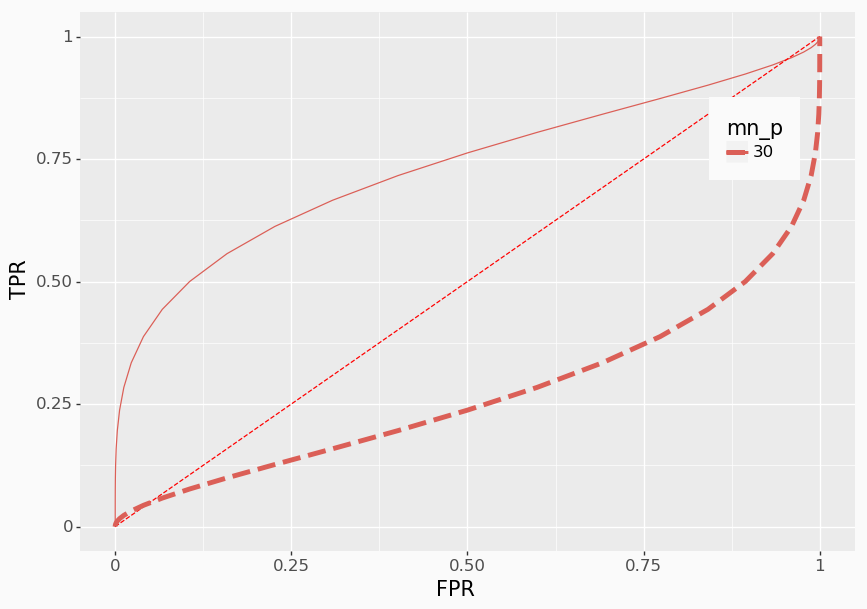

<ggplot: (13522892)>

In [113]:
# cdf_pos=stats.norm.cdf(range(100,0,-1), scale=7, loc=45)
# cdf_neg=stats.norm.cdf(range(100,0,-1), scale=5, loc=35)
# df_cdf = pd.DataFrame({'TPR':1-cdf_pos,'FPR':1-cdf_neg})
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})
p2 = (ggplot() + geom_line(df_roc_p,aes('FPR','TPR',color='mn_p')) + 
 geom_line(diag, aes('x','y'),linetype='dashed',color='r') + 
 geom_line(df_roc_n, aes('TNR','FNR',color='mn_p'),linetype='dashed',size=2) + 
 tex_theme)
    
p2

In [119]:
df_roc_p.FPR.count()

100

In [120]:
df_roc_p.FPR.sum() + df_roc_n.FNR.sum()

94.99999049165956

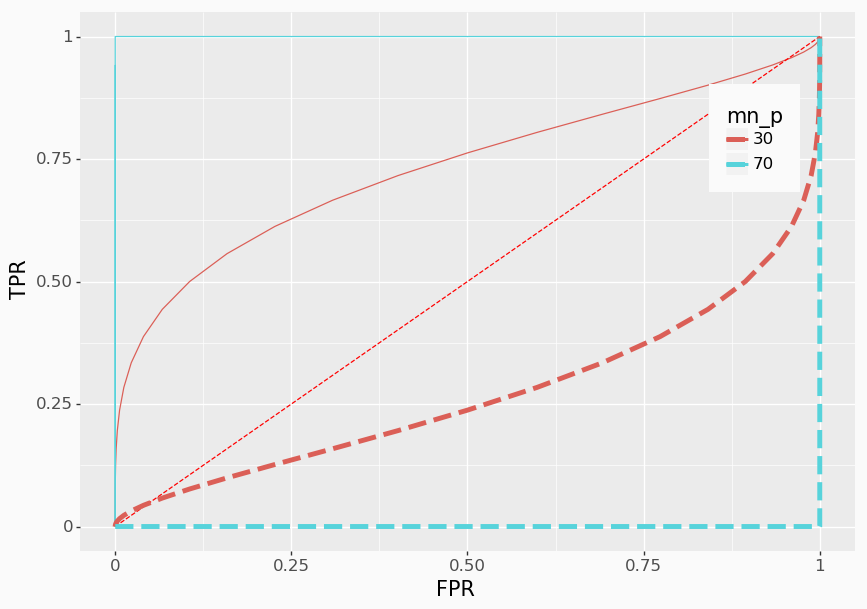

<ggplot: (12545621)>

In [103]:
# cdf_pos=stats.norm.cdf(range(100,0,-1), scale=7, loc=45)
# cdf_neg=stats.norm.cdf(range(100,0,-1), scale=5, loc=35)
# df_cdf = pd.DataFrame({'TPR':1-cdf_pos,'FPR':1-cdf_neg})
diag = pd.DataFrame({'x':[0,1],'y':[0,1]})
p2 = (ggplot() + geom_line(df_roc_p,aes('FPR','TPR',color='mn_p')) + 
 geom_line(diag, aes('x','y'),linetype='dashed',color='r') + 
 geom_line(df_roc_n, aes('TNR','FNR',color='mn_p'),linetype='dashed',size=2) + 
 tex_theme)
    
p2

In [75]:
df = pd.DataFrame({'x':[],'y':[],'grp':[]})
df2 =pd.DataFrame({'x':[0,1],'y':[0,2],'grp':'tst'})
df = df.append(df2, ignore_index=True)

# Stat calculations

In [76]:
df

x    y  grp
0  0.0  0.0  tst
1  1.0  2.0  tst

In [140]:
TP = 17
FP = 6
TN = 65
FN = 14
sens = round(TP/(TP+FN)*100)
spec = round(TN/(TN+FP)*100)
ppv = round(TP/(TP+FP)*100)
npv = round(TN/(TN+FN)*100)
acc = round((TP+TN)/(TP+TN+FP+FN)*100)
f1 = round(2/(1/sens + 1/ppv))
f'HTN sens: {sens}, spec: {spec}, ppv: {ppv}, npv: {npv}, acc: {acc}, f1: {f1}'

'HTN sens: 55, spec: 92, ppv: 74, npv: 82, acc: 80, f1: 63'

In [139]:
TP = 600
FP = 734
TN = 25480
FN = 61
sens = round(TP/(TP+FN)*100)
spec = round(TN/(TN+FP)*100)
ppv = round(TP/(TP+FP)*100)
npv = round(TN/(TN+FN)*100)
acc = round((TP+TN)/(TP+TN+FP+FN)*100)
f1 = round(2/(1/sens + 1/ppv))
f'AAA sens: {sens}, spec: {spec}, ppv: {ppv}, npv: {npv}, acc: {acc}, f1: {f1}'

'AAA sens: 91, spec: 97, ppv: 45, npv: 100, acc: 97, f1: 60'

In [275]:
TP = 649
FP = 17497
TN = 49792
FN = 5532
sens = round(TP/(TP+FN)*100)
spec = round(TN/(TN+FP)*100)
ppv = round(TP/(TP+FP)*100)
npv = round(TN/(TN+FN)*100)
acc = round((TP+TN)/(TP+TN+FP+FN)*100)
f1 = round(2/(1/sens + 1/ppv))
f'LDCT sens: {sens}, spec: {spec}, ppv: {ppv}, npv: {npv}, acc: {acc}, f1: {f1}'

'LDCT sens: 10, spec: 74, ppv: 4, npv: 90, acc: 69, f1: 6'

In [137]:
TP = 32
FP = 23
TN = 133
FN = 30
sens = round(TP/(TP+FN)*100)
spec = round(TN/(TN+FP)*100)
ppv = round(TP/(TP+FP)*100)
npv = round(TN/(TN+FN)*100)
acc = round((TP+TN)/(TP+TN+FP+FN)*100)
f1 = round(2/(1/sens + 1/ppv))
f'KSADS sens: {sens}, spec: {spec}, ppv: {ppv}, npv: {npv}, acc: {acc}, f1: {f1}'

'KSADS sens: 52, spec: 85, ppv: 58, npv: 82, acc: 76, f1: 55'

# Regression Metrics

## Growth curves

In [406]:
df_growth = pd.read_table(f'{PATH}data/1977coefficients2.txt',delimiter='\t')
df_growth.head()

KNOT             A            B1             B2             B3  \
0             0  0.464421D 02  0.417604D 01  -0.276242D 00   0.875978D-02   
1  0.900000D 01  0.680368D 02  0.133232D 01  -0.397275D-01   0.958204D-03   
2  0.240000D 02  0.823168D 02  0.787284D 00   0.339168D-02  -0.591845D-03   
3             0  0.453545D 02  0.414118D 01  -0.292865D 00   0.993348D-02   
4  0.900000D 01  0.661445D 02  0.128345D 01  -0.246609D-01   0.422265D-03   

   SEX  AGE  PERCENTILE  CHART  
0    M  1.0         5.0    1.0  
1  NaN  NaN         NaN    NaN  
2  NaN  NaN         NaN    NaN  
3    F  1.0         5.0    1.0  
4  NaN  NaN         NaN    NaN

In [404]:
df_growth.shape

(308, 9)

In [399]:
def convert_to_float(df_series):
    col_tmp = df_series.str.split('D',expand=True)
    col_tmp.fillna(0,inplace=True)
    col_tmp = col_tmp.astype(float)
    df_series = col_tmp.iloc[:,0]*10**col_tmp.iloc[:,1]
    return df_series

In [407]:
df_growth.KNOT = convert_to_float(df_growth.KNOT)
df_growth.A = convert_to_float(df_growth.A)
df_growth.B1 = convert_to_float(df_growth.B1)
df_growth.B2 = convert_to_float(df_growth.B2)
df_growth.B3 = convert_to_float(df_growth.B3)
df_growth.head(10)

KNOT         A        B1        B2        B3  SEX  AGE  PERCENTILE  CHART
0   0.0  46.44210  4.176040 -0.276242  0.008760    M  1.0         5.0    1.0
1   9.0  68.03680  1.332320 -0.039727  0.000958  NaN  NaN         NaN    NaN
2  24.0  82.31680  0.787284  0.003392 -0.000592  NaN  NaN         NaN    NaN
3   0.0  45.35450  4.141180 -0.292865  0.009933    F  1.0         5.0    1.0
4   9.0  66.14450  1.283450 -0.024661  0.000422  NaN  NaN         NaN    NaN
5  24.0  81.27270  0.828649 -0.005659 -0.000233  NaN  NaN         NaN    NaN
6   0.0   2.54353  0.606179  0.015540 -0.002513    M  1.0         5.0    2.0
7   6.0   6.19726  0.521262 -0.029693  0.000817  NaN  NaN         NaN    NaN
8  18.0   9.58785  0.161441 -0.000292 -0.000024  NaN  NaN         NaN    NaN
9   0.0   2.36498  0.603840  0.005435 -0.001801    F  1.0         5.0    2.0

In [409]:
df_growth.ffill(inplace=True)
df_growth.head(10)

KNOT         A        B1        B2        B3 SEX  AGE  PERCENTILE  CHART
0   0.0  46.44210  4.176040 -0.276242  0.008760   M  1.0         5.0    1.0
1   9.0  68.03680  1.332320 -0.039727  0.000958   M  1.0         5.0    1.0
2  24.0  82.31680  0.787284  0.003392 -0.000592   M  1.0         5.0    1.0
3   0.0  45.35450  4.141180 -0.292865  0.009933   F  1.0         5.0    1.0
4   9.0  66.14450  1.283450 -0.024661  0.000422   F  1.0         5.0    1.0
5  24.0  81.27270  0.828649 -0.005659 -0.000233   F  1.0         5.0    1.0
6   0.0   2.54353  0.606179  0.015540 -0.002513   M  1.0         5.0    2.0
7   6.0   6.19726  0.521262 -0.029693  0.000817   M  1.0         5.0    2.0
8  18.0   9.58785  0.161441 -0.000292 -0.000024   M  1.0         5.0    2.0
9   0.0   2.36498  0.603840  0.005435 -0.001801   F  1.0         5.0    2.0

In [411]:
df_growth.AGE.unique()

array([1., 2., 3., 4.])

In [419]:
df_weight = df_growth.loc[((df_growth.AGE>1) & (df_growth.CHART==2)),:]
df_weight.head()

KNOT         A        B1        B2            B3 SEX  AGE  PERCENTILE  \
176   18.0   9.71896  0.128036  0.000073  5.344420e-07   M  2.0         5.0   
177   96.0  20.40440  0.149201  0.000198  1.652660e-05   M  2.0         5.0   
178  156.0  33.63970  0.351473  0.003173 -5.719720e-05   M  2.0         5.0   
179  204.0  51.49540  0.260732 -0.005063  4.072810e-05   M  2.0         5.0   
180   18.0   9.01814  0.160928 -0.001130  1.039520e-05   F  2.0         5.0   

     CHART  
176    2.0  
177    2.0  
178    2.0  
179    2.0  
180    2.0

In [423]:
df_wt_age = pd.read_csv(f'{PATH}data/wtage.csv')
df_wt_age.head()

Sex  Agemos         L          M         S         P3         P5  \
0    1    24.0 -0.206152  12.670763  0.108126  10.382090  10.640090   
1    1    24.5 -0.216501  12.741544  0.108166  10.441442  10.700513   
2    1    25.5 -0.239790  12.881023  0.108275  10.558473  10.819575   
3    1    26.5 -0.266316  13.018424  0.108421  10.673803  10.936812   
4    1    27.5 -0.295755  13.154497  0.108605  10.787982  11.052801   

         P10        P25        P50        P75        P90        P95        P97  
0  11.052656  11.785975  12.670763  13.636919  14.583398  15.187773  15.596483  
1  11.114904  11.851817  12.741544  13.713860  14.667158  15.276296  15.688406  
2  11.237473  11.981419  12.881023  13.865896  14.833316  15.452424  15.871699  
3  11.358059  12.108888  13.018424  14.016230  14.998478  15.628189  16.055142  
4  11.477280  12.234907  13.154497  14.165673  15.163512  15.804500  16.239671

In [480]:
df_wtage_g = df_wt_age.loc[df_wt_age.Sex==2,['Agemos','P3','P5','P10','P25','P50','P75','P90','P95','P97']]
df_wtage_g.Agemos = df_wtage_g.Agemos/12
df_wtage_g.reset_index(drop=True, inplace=True)
df_wtage_g.head()

Agemos         P3         P5        P10        P25        P50        P75  \
0  2.000000   9.985668  10.210274  10.573735  11.233568  12.055040  12.986670   
1  2.041667  10.048808  10.274829  10.640760  11.305666  12.134555  13.076132   
2  2.125000  10.171734  10.400664  10.771667  11.446967  12.291025  13.252935   
3  2.208333  10.290790  10.522736  10.898985  11.585013  12.444693  13.427531   
4  2.291667  10.406644  10.641710  11.023380  11.720466  12.596223  13.600594   

         P90        P95        P97  
0  13.937664  14.566365  15.001564  
1  14.039025  14.676586  15.118389  
2  14.240165  14.895872  15.351221  
3  14.439838  15.114276  15.583627  
4  14.638729  15.332495  15.816318

In [481]:
df_wtage_g.shape

(218, 10)

In [489]:
[0]+list(range(25,218,12))

[0,
 25,
 37,
 49,
 61,
 73,
 85,
 97,
 109,
 121,
 133,
 145,
 157,
 169,
 181,
 193,
 205,
 217]

In [486]:
df_wtage_g.Agemos

0       2.000000
1       2.041667
2       2.125000
3       2.208333
4       2.291667
5       2.375000
6       2.458333
7       2.541667
8       2.625000
9       2.708333
10      2.791667
11      2.875000
12      2.958333
13      3.041667
14      3.125000
15      3.208333
16      3.291667
17      3.375000
18      3.458333
19      3.541667
20      3.625000
21      3.708333
22      3.791667
23      3.875000
24      3.958333
25      4.041667
26      4.125000
27      4.208333
28      4.291667
29      4.375000
30      4.458333
31      4.541667
32      4.625000
33      4.708333
34      4.791667
35      4.875000
36      4.958333
37      5.041667
38      5.125000
39      5.208333
40      5.291667
41      5.375000
42      5.458333
43      5.541667
44      5.625000
45      5.708333
46      5.791667
47      5.875000
48      5.958333
49      6.041667
50      6.125000
51      6.208333
52      6.291667
53      6.375000
54      6.458333
55      6.541667
56      6.625000
57      6.708333
58      6.7916

In [463]:
df_wt_melt = df_wtage_g.melt(id_vars=['Agemos'],var_name='Percentile')
# df_wt_melt.Agemos = df_wt_melt.Agemos/12
# df_wt_melt.rename(columns={'variable':'Percentile'}, inplace=True)
df_wt_melt.Percentile = df_wt_melt.Percentile.str.replace('P','').str.zfill(2)
df_wt_melt.head()

Agemos Percentile      value
0  2.000000         03   9.985668
1  2.041667         03  10.048808
2  2.125000         03  10.171734
3  2.208333         03  10.290790
4  2.291667         03  10.406644

In [602]:
p = (ggplot(df_wt_melt, aes('Agemos','value',color='Percentile')) 
     + geom_line(size=1.5) 
     + xlab('Age (years)') 
     + ylab('Weight (kg)') 
     + ylim(10,90)
     + tex_theme2
    )
p
# p.save(f'{PATH_I}/growth_curves.pdf')

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:688: UserWarning: Saving 10 x 7 in image.
  from_inches(height, units), units))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\ggplot.py:689: UserWarning: Filename: /MyDocuments/GitHub/curriculum/dig_trans_healthcare/Course/04_evaluating_predictions/images/growth_curves.pdf
  warn('Filename: {}'.format(filename))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\geoms\geom_path.py:76: UserWarning: geom_path: Removed 1 rows containing missing values.
  warn(msg.format(n1-n2))


In [622]:
yrly_idx = [0]+list(range(13,218,12))
df_wtage_yrly = df_wtage_g.iloc[yrly_idx,:]
df_wtage_yrly['qrng'] = df_wtage_yrly.P97.subtract(df_wtage_yrly.P3)/8
df_wtage_yrly.reset_index(drop=True, inplace=True)
df_wtage_yrly

E:\Anaconda3\envs\curriculum\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Agemos         P3         P5        P10        P25        P50  \
0    2.000000   9.985668  10.210274  10.573735  11.233568  12.055040   
1    3.041667  11.388241  11.655419  12.092586  12.902215  13.941083   
2    4.041667  12.774318  13.090120  13.611160  14.590933  15.878237   
3    5.041667  14.342773  14.709237  15.317582  16.474709  18.023139   
4    6.041667  16.011863  16.436080  17.143270  18.499041  20.336360   
5    7.041667  17.728577  18.228046  19.063003  20.671681  22.868043   
6    8.041667  19.544811  20.145350  21.151106  23.094460  25.757017   
7    9.041667  21.588366  22.316772  23.538130  25.901669  29.142912   
8   10.041667  23.991428  24.865165  26.331318  29.170720  33.063923   
9   11.041667  26.818592  27.835641  29.543206  32.852300  37.390887   
10  12.041667  30.017604  31.150939  33.054961  36.749503  41.827980   
11  13.041667  33.406169  34.607152  36.626884  40.555641  45.983687   
12  14.041667  36.701439  37.913416  39.954666  43.940122  49.490754   
13  15.041667  39.590123  40.768390  42.756266  46.654453  52.135682   
14  16.041667  41.827340  42.956493  44.864302  48.619678  53.945437   
15  17.041667  43.336460  44.435503  46.293817  49.959162  55.182168   
16  18.041667  44.247152  45.360202  47.241575  50.950142  56.229696   
17  19.041667  44.795212  45.970093  47.952804  51.847202  57.351758   
18  20.000000  45.046548  46.289634  48.383460  52.478764  58.218973   

          P75        P90        P95        P97      qrng  
0   12.986670  13.937664  14.566365  15.001564  0.626987  
1   15.164522  16.467890  17.362444  17.998070  0.826229  
2   17.441492  19.168577  20.394087  21.286159  1.063980  
3   19.950483  22.146041  23.750236  24.944013  1.325155  
4   22.662941  25.371452  27.392742  28.921619  1.613720  
5   25.675490  28.979794  31.470488  33.368335  1.954970  
6   29.170459  33.194350  36.226995  38.535368  2.373820  
7   33.293931  38.167624  41.818845  44.582256  2.874236  
8   38.038779  43.850013  48.175006  51.429128  3.429713  
9   43.186546  49.942797  54.957035  58.720125  3.987692  
10  48.333956  55.950475  61.627010  65.901027  4.485428  
11  52.997450  61.312812  67.594477  72.376329  4.871270  
12  56.764233  65.575275  72.392748  77.688167  5.123341  
13  59.444043  68.548771  75.828047  81.648301  5.257272  
14  61.162408  70.404986  78.052108  84.366388  5.317381  
15  62.327613  71.637072  79.515063  86.167061  5.353825  
16  63.443199  72.825635  80.751722  87.434618  5.398433  
17  64.778380  74.237439  82.021395  88.420660  5.453181  
18  65.852380  75.351650  82.953755  89.044851  5.499788

In [726]:
dist_val = np.abs(np.random.RandomState(42).normal(0,1,19))
dist_val2 = (np.random.RandomState(43).normal(0,1,19))
col_sel = ['P3']
for x in df_wtage_yrly.columns[1:-1]:
    col_sel += [x]*2 
g_val = []
g_val2 = []
for i,v in df_wtage_yrly.iterrows():
    g_val.append(dist_val[i]*v.qrng+v[col_sel[i]])
    g_val2.append(dist_val2[i]*v.qrng+v.P50+12)
df_error = pd.DataFrame({'x':df_wtage_yrly.Agemos, 'P50':df_wtage_yrly.P50,'blue':g_val, 'green':g_val2})
df_error['red'] = df_wtage_yrly.P50 + np.abs(dist_val*df_wtage_yrly.qrng*2)
# df_error.red[13:15] = df_error.red[13:15]+12
# df_error.red[15] = df_error.red[15]-5
# df_error.blue[13:] = df_error.blue[13:]-15

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\geoms\geom_path.py:76: UserWarning: geom_path: Removed 1 rows containing missing values.
  warn(msg.format(n1-n2))
E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\layer.py:450: UserWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


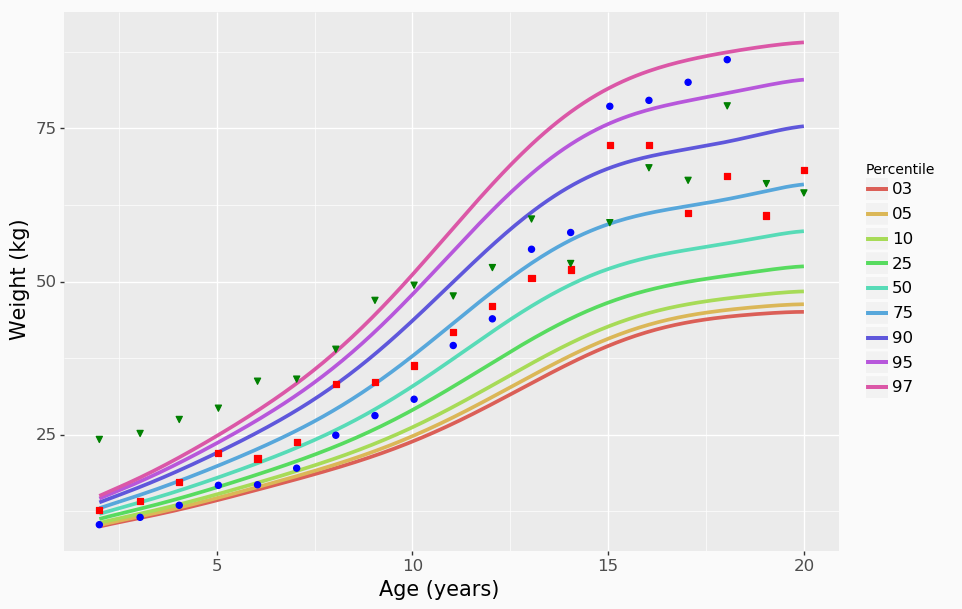

<ggplot: (-9223372036839666260)>

In [731]:
p = (ggplot(df_wt_melt, aes('Agemos','value',color='Percentile')) 
     + geom_line(size=1.5) 
     + geom_point(df_error, aes('x','blue'), show_legend=False, color='b', shape='o',size=2)
     + geom_point(df_error, aes('x','red'), show_legend=False, color='r',shape='s',size=2)
     + geom_point(df_error, aes('x','green'), show_legend=False, color='g',shape='v',size=2)
     + xlab('Age (years)') 
     + ylab('Weight (kg)') 
     + ylim(10,90)
     + tex_theme2
    )
     
p
# p.save(f'{PATH_I}/growth_curves_measured.pdf')

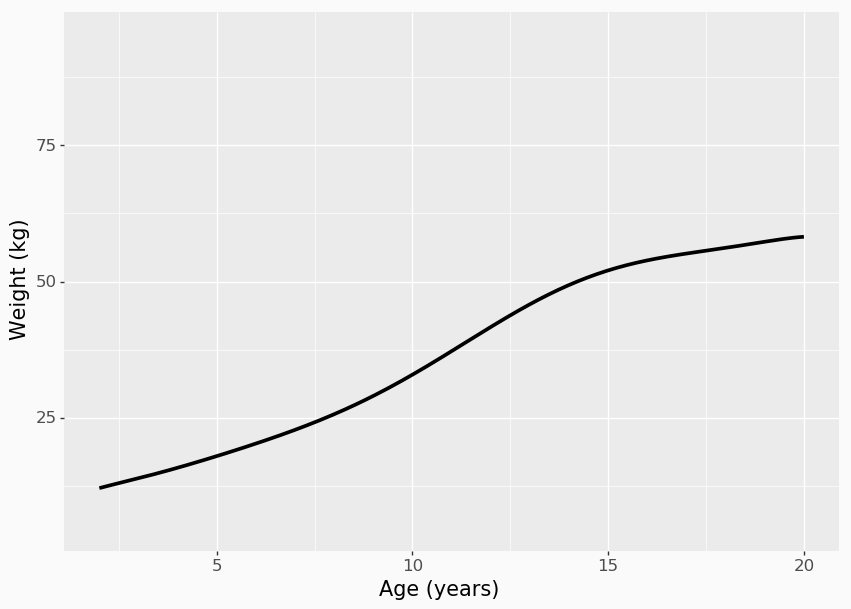

<ggplot: (-9223372036838678044)>

In [608]:
p = (ggplot(df_wtage_g, aes('Agemos', 'P50')) 
     + geom_line(size=1.5) 
     + xlab('Age (years)') 
     + ylab('Weight (kg)')
     + ylim(5,95)
     + tex_theme2
    )
p
# p.save(f'{PATH_I}/growth_curves_p50.pdf')

E:\Anaconda3\envs\curriculum\lib\site-packages\plotnine\layer.py:450: UserWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


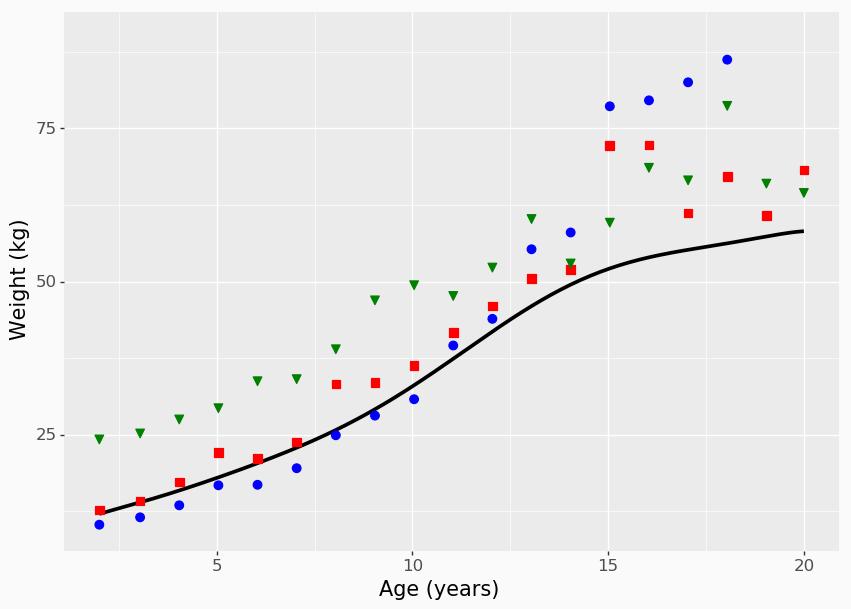

<ggplot: (15498518)>

In [733]:
p = (ggplot(df_wtage_g, aes('Agemos', 'P50')) 
     + geom_line(size=1.5)
     + geom_point(df_error, aes('x','blue'), show_legend=False, color='b', shape='o',size=3)
     + geom_point(df_error, aes('x','red'), show_legend=False, color='r',shape='s',size=3)
     + geom_point(df_error, aes('x','green'), show_legend=False, color='g',shape='v',size=3)
     + xlab('Age (years)') 
     + ylab('Weight (kg)')
     + ylim(10,90)
     + tex_theme2
    )
p
# p.save(f'{PATH_I}/growth_curves_measured_p50.pdf')

In [734]:
df_error.astype(int).transpose()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
x       2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19   
P50    12  13  15  18  20  22  25  29  33  37  41  45  49  52  53  55  56  57   
blue   10  11  13  16  16  19  24  28  30  39  43  55  58  78  79  82  86  90   
green  24  25  27  29  33  34  38  46  49  47  52  60  52  59  68  66  78  65   
red    12  14  17  22  21  23  33  33  36  41  45  50  51  72  72  61  67  60   

       18  
x      20  
P50    58  
blue   94  
green  64  
red    68

In [735]:
df_error.astype(int).transpose().to_latex(bold_rows=True)

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrrr}\n\\toprule\n{} &  0  &  1  &  2  &  3  &  4  &  5  &  6  &  7  &  8  &  9  &  10 &  11 &  12 &  13 &  14 &  15 &  16 &  17 &  18 \\\\\n\\midrule\n\\textbf{x    } &   2 &   3 &   4 &   5 &   6 &   7 &   8 &   9 &  10 &  11 &  12 &  13 &  14 &  15 &  16 &  17 &  18 &  19 &  20 \\\\\n\\textbf{P50  } &  12 &  13 &  15 &  18 &  20 &  22 &  25 &  29 &  33 &  37 &  41 &  45 &  49 &  52 &  53 &  55 &  56 &  57 &  58 \\\\\n\\textbf{blue } &  10 &  11 &  13 &  16 &  16 &  19 &  24 &  28 &  30 &  39 &  43 &  55 &  58 &  78 &  79 &  82 &  86 &  90 &  94 \\\\\n\\textbf{green} &  24 &  25 &  27 &  29 &  33 &  34 &  38 &  46 &  49 &  47 &  52 &  60 &  52 &  59 &  68 &  66 &  78 &  65 &  64 \\\\\n\\textbf{red  } &  12 &  14 &  17 &  22 &  21 &  23 &  33 &  33 &  36 &  41 &  45 &  50 &  51 &  72 &  72 &  61 &  67 &  60 &  68 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [727]:
for i in ['blue','red','green']:
    mae = round(metrics.mean_absolute_error(df_error.P50,df_error[i]),3)
    mape = round(100*np.mean(np.abs((df_error.P50 - df_error[i])/df_error.P50)),3)
    mse = round(metrics.mean_squared_error(df_error.P50,df_error[i]),3)
    rmse = round(np.sqrt(mse),3)
    msle = round(metrics.mean_squared_log_error(df_error.P50,df_error[i]),3)
    r2 = round(metrics.r2_score(df_error.P50,df_error[i]),3)
    ev = round(metrics.explained_variance_score(df_error.P50,df_error[i]),3)
    print(f'{i}: mae:{mae}, mape:{mape}, mse:{mse}, rmse:{rmse}, msle:{msle}, r2:{r2}, ev:{ev}')

blue: mae:11.528, mape:24.643, mse:293.544, rmse:17.133, msle:0.067, r2:-0.12, ev:0.227
red: mae:5.653, mape:13.793, mse:61.967, rmse:7.872, msle:0.022, r2:0.764, ev:0.886
green: mae:11.962, mape:42.712, mse:160.046, rmse:12.651, msle:0.136, r2:0.39, ev:0.935


In [737]:
for i in ['blue','red','green']:
    mae = round(metrics.mean_absolute_error(df_error.P50,df_error[i]),3)
    mape = round(100*np.mean(np.abs((df_error.P50 - df_error[i])/df_error.P50)),3)
    mse = round(metrics.mean_squared_error(df_error.P50,df_error[i]),3)
    rmse = round(np.sqrt(mse),3)
    msle = round(metrics.mean_squared_log_error(df_error.P50,df_error[i]),3)
    r2 = round(metrics.r2_score(df_error.P50,df_error[i]),3)
    ev = round(metrics.explained_variance_score(df_error.P50,df_error[i]),3)
    print(f'{i}: {mae} &  {mape} & {mse} & {rmse} & {msle} & {r2} & {ev}')

blue: 11.528 &  24.643 & 293.544 & 17.133 & 0.067 & -0.12 & 0.227
red: 5.653 &  13.793 & 61.967 & 7.872 & 0.022 & 0.764 & 0.886
green: 11.962 &  42.712 & 160.046 & 12.651 & 0.136 & 0.39 & 0.935
